# PAI CA1 Group 7

### Importing Libaries

In [73]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Loading Dataset

In [74]:
%%time
file_path = './dataset/taxi_data.csv'
chunksize = 10 ** 6
with pd.read_csv(file_path, chunksize=chunksize) as reader:
    df = pd.concat([chunk for chunk in reader])

df.head()

CPU times: total: 6.62 s
Wall time: 8.65 s


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,driver_id,label,driver_name,years_of_exp,gender,car_brand,driver_rating,age,age_of_car
0,0,8.000,143.300,-1.706,-9.271,-1.209,-0.029,-0.033,0.015,2.000,0.000,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.700,53,20
1,0,8.000,143.300,-1.417,-9.548,-1.861,-0.022,0.005,-0.026,3.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.700,53,20
2,0,8.000,143.300,-0.347,-9.533,-1.205,0.015,-0.050,0.025,9.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.700,53,20
3,0,8.000,143.300,-0.601,-9.452,-2.158,0.004,-0.012,-0.004,11.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.700,53,20
4,0,8.000,143.300,-0.598,-9.863,-1.673,-0.000,0.000,-0.010,12.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.700,53,20


In [75]:
df.shape

(7346552, 20)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7346552 entries, 0 to 7346551
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   bookingID       int64  
 1   Accuracy        float64
 2   Bearing         float64
 3   acceleration_x  float64
 4   acceleration_y  float64
 5   acceleration_z  float64
 6   gyro_x          float64
 7   gyro_y          float64
 8   gyro_z          float64
 9   second          float64
 10  speed           float64
 11  driver_id       int64  
 12  label           int64  
 13  driver_name     object 
 14  years_of_exp    int64  
 15  gender          object 
 16  car_brand       object 
 17  driver_rating   float64
 18  age             int64  
 19  age_of_car      int64  
dtypes: float64(11), int64(6), object(3)
memory usage: 1.1+ GB


#### Double Checking whether there is any NULL or missing values

In [77]:
rows, columns = df.shape

num_null_rows = df.isna().any(axis=1).sum()
pct_null_rows = num_null_rows / rows

print(f'No. of rows with at least one missing value: {num_null_rows}')
print(f'Percentage of rows with at least one missing value: {round((pct_null_rows) * 100, 2)}%')

No. of rows with at least one missing value: 0
Percentage of rows with at least one missing value: 0.0%


### Setting up for Analysis

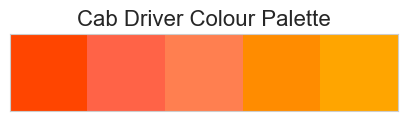

In [78]:
# set colour palette for better visualisations
palette = ['#FF4500', '#FF6347', '#FF7F50', '#FF8C00', '#FFA500']

sns.palplot(palette)
plt.title('Cab Driver Colour Palette', fontsize=16)
plt.grid(False)
plt.show()

## Exploratory Data Analysis
As we have done our data cleaning and preprocessing in SQL, we can now perform some exploratory data analysis on our dataset

In [79]:
%%time
# We will be using dask to read in the data as it is faster than pandas
dask_df = dd.read_csv(file_path)
dask_df =  dask_df.persist() # persist the data in memory
dask_df.head()

CPU times: total: 3.09 s
Wall time: 4.38 s


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,driver_id,label,driver_name,years_of_exp,gender,car_brand,driver_rating,age,age_of_car
0,0,8.000,143.300,-1.706,-9.271,-1.209,-0.029,-0.033,0.015,2.000,0.000,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.700,53,20
1,0,8.000,143.300,-1.417,-9.548,-1.861,-0.022,0.005,-0.026,3.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.700,53,20
2,0,8.000,143.300,-0.347,-9.533,-1.205,0.015,-0.050,0.025,9.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.700,53,20
3,0,8.000,143.300,-0.601,-9.452,-2.158,0.004,-0.012,-0.004,11.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.700,53,20
4,0,8.000,143.300,-0.598,-9.863,-1.673,-0.000,0.000,-0.010,12.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.700,53,20


## Descriptive Analysis

In [80]:
dask_df.compute().shape

(7346552, 20)

In [81]:
dask_df.compute().isna().sum()

bookingID         0
Accuracy          0
Bearing           0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
second            0
speed             0
driver_id         0
label             0
driver_name       0
years_of_exp      0
gender            0
car_brand         0
driver_rating     0
age               0
age_of_car        0
dtype: int64

In [82]:
unqiue_values = dask_df.nunique().compute().sort_values(ascending=False)
unqiue_values

acceleration_y    59261
gyro_y            57633
Bearing           53208
acceleration_z    52095
gyro_x            44536
acceleration_x    43637
gyro_z            43417
bookingID         20000
speed              9946
Accuracy           9492
second             6198
driver_id           500
driver_name         500
age_of_car           38
driver_rating        31
years_of_exp         21
age                  14
car_brand            12
label                 2
gender                2
dtype: int64

## Summary Statistics

In [83]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
dask_df.describe().compute().T

,count,mean,std,min,25%,50%,75%,max
bookingID,7346552.000,818325455111.994,495325235467.501,0.000,506806140972.000,884763263111.000,1305670058069.000,1709396983975.000
Accuracy,7346552.000,11.617,87.169,0.000,3.900,4.550,8.000,6070.100
Bearing,7346552.000,168.932,107.200,0.000,80.310,173.000,266.000,360.000
acceleration_x,7346552.000,0.069,1.420,-38.984,-0.466,0.086,0.663,66.873
acceleration_y,7346552.000,4.466,8.130,-57.800,1.853,9.175,9.738,61.159
acceleration_z,7346552.000,0.896,3.251,-78.448,-0.790,0.953,3.010,78.056
gyro_x,7346552.000,-0.002,0.143,-48.456,-0.025,-0.000,0.025,30.709
gyro_y,7346552.000,0.000,0.335,-57.345,-0.029,0.001,0.033,80.315
gyro_z,7346552.000,-0.000,0.147,-53.554,-0.018,0.000,0.019,45.060
second,7346552.000,3720.743,1389856.188,0.000,248.000,533.000,889.000,619317000.000


## Reducing Memory of our dataframe

In [84]:
dask_df.compute().info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 7346552 entries, 0 to 526009
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   bookingID       int64  
 1   Accuracy        float64
 2   Bearing         float64
 3   acceleration_x  float64
 4   acceleration_y  float64
 5   acceleration_z  float64
 6   gyro_x          float64
 7   gyro_y          float64
 8   gyro_z          float64
 9   second          float64
 10  speed           float64
 11  driver_id       int64  
 12  label           int64  
 13  driver_name     object 
 14  years_of_exp    int64  
 15  gender          object 
 16  car_brand       object 
 17  driver_rating   float64
 18  age             int64  
 19  age_of_car      int64  
dtypes: float64(11), int64(6), object(3)
memory usage: 2.3 GB


We can see that our memory load for our pandas dataframe is at 2.3GB, so we are going to shrink the memory load using some techniques

In [99]:
convert_dict = {
    'driver_id': 'int32',
    'label': 'category',
    'gender': 'category',
    'years_of_exp': 'int16',
    'age': 'int16',
    'age_of_car': 'int16'
}

# Convert the columns to the specified types
df_new = dask_df.compute().astype(convert_dict)
df_new.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 7346552 entries, 0 to 526009
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   bookingID       int64   
 1   Accuracy        float64 
 2   Bearing         float64 
 3   acceleration_x  float64 
 4   acceleration_y  float64 
 5   acceleration_z  float64 
 6   gyro_x          float64 
 7   gyro_y          float64 
 8   gyro_z          float64 
 9   second          float64 
 10  speed           float64 
 11  driver_id       int32   
 12  label           category
 13  driver_name     object  
 14  years_of_exp    int16   
 15  gender          category
 16  car_brand       object  
 17  driver_rating   float64 
 18  age             int16   
 19  age_of_car      int16   
dtypes: category(2), float64(11), int16(3), int32(1), int64(1), object(2)
memory usage: 1.7 GB


We have successfully shrunked our memory by around 600MBs

In [97]:
df_new.describe().T

,count,mean,std,min,25%,50%,75%,max
bookingID,7346552.000,818325455111.994,495325235467.501,0.000,377957122216.000,807453851664.000,1254130450446.000,1709396983975.000
Accuracy,7346552.000,11.617,87.169,0.000,3.900,4.260,8.000,6070.100
Bearing,7346552.000,168.932,107.200,0.000,78.000,168.690,262.390,360.000
acceleration_x,7346552.000,0.069,1.420,-38.984,-0.507,0.061,0.633,66.873
acceleration_y,7346552.000,4.466,8.130,-57.800,-2.027,9.082,9.709,61.159
acceleration_z,7346552.000,0.896,3.251,-78.448,-0.929,0.777,2.752,78.056
gyro_x,7346552.000,-0.002,0.143,-48.456,-0.027,-0.001,0.023,30.709
gyro_y,7346552.000,0.000,0.335,-57.345,-0.030,0.000,0.031,80.315
gyro_z,7346552.000,-0.000,0.147,-53.554,-0.019,0.000,0.018,45.060
second,7346552.000,3720.743,1389856.188,0.000,241.000,520.000,862.000,619317000.000


## Checking for Outliers

In [112]:
continuous_cols  = df_new.select_dtypes(include=['int16', 'int32','int64','float64']).columns.drop(['bookingID', 'driver_id'])
continuous_cols 

Index(['Accuracy', 'Bearing', 'acceleration_x', 'acceleration_y',
       'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z', 'second', 'speed',
       'years_of_exp', 'driver_rating', 'age', 'age_of_car'],
      dtype='object')

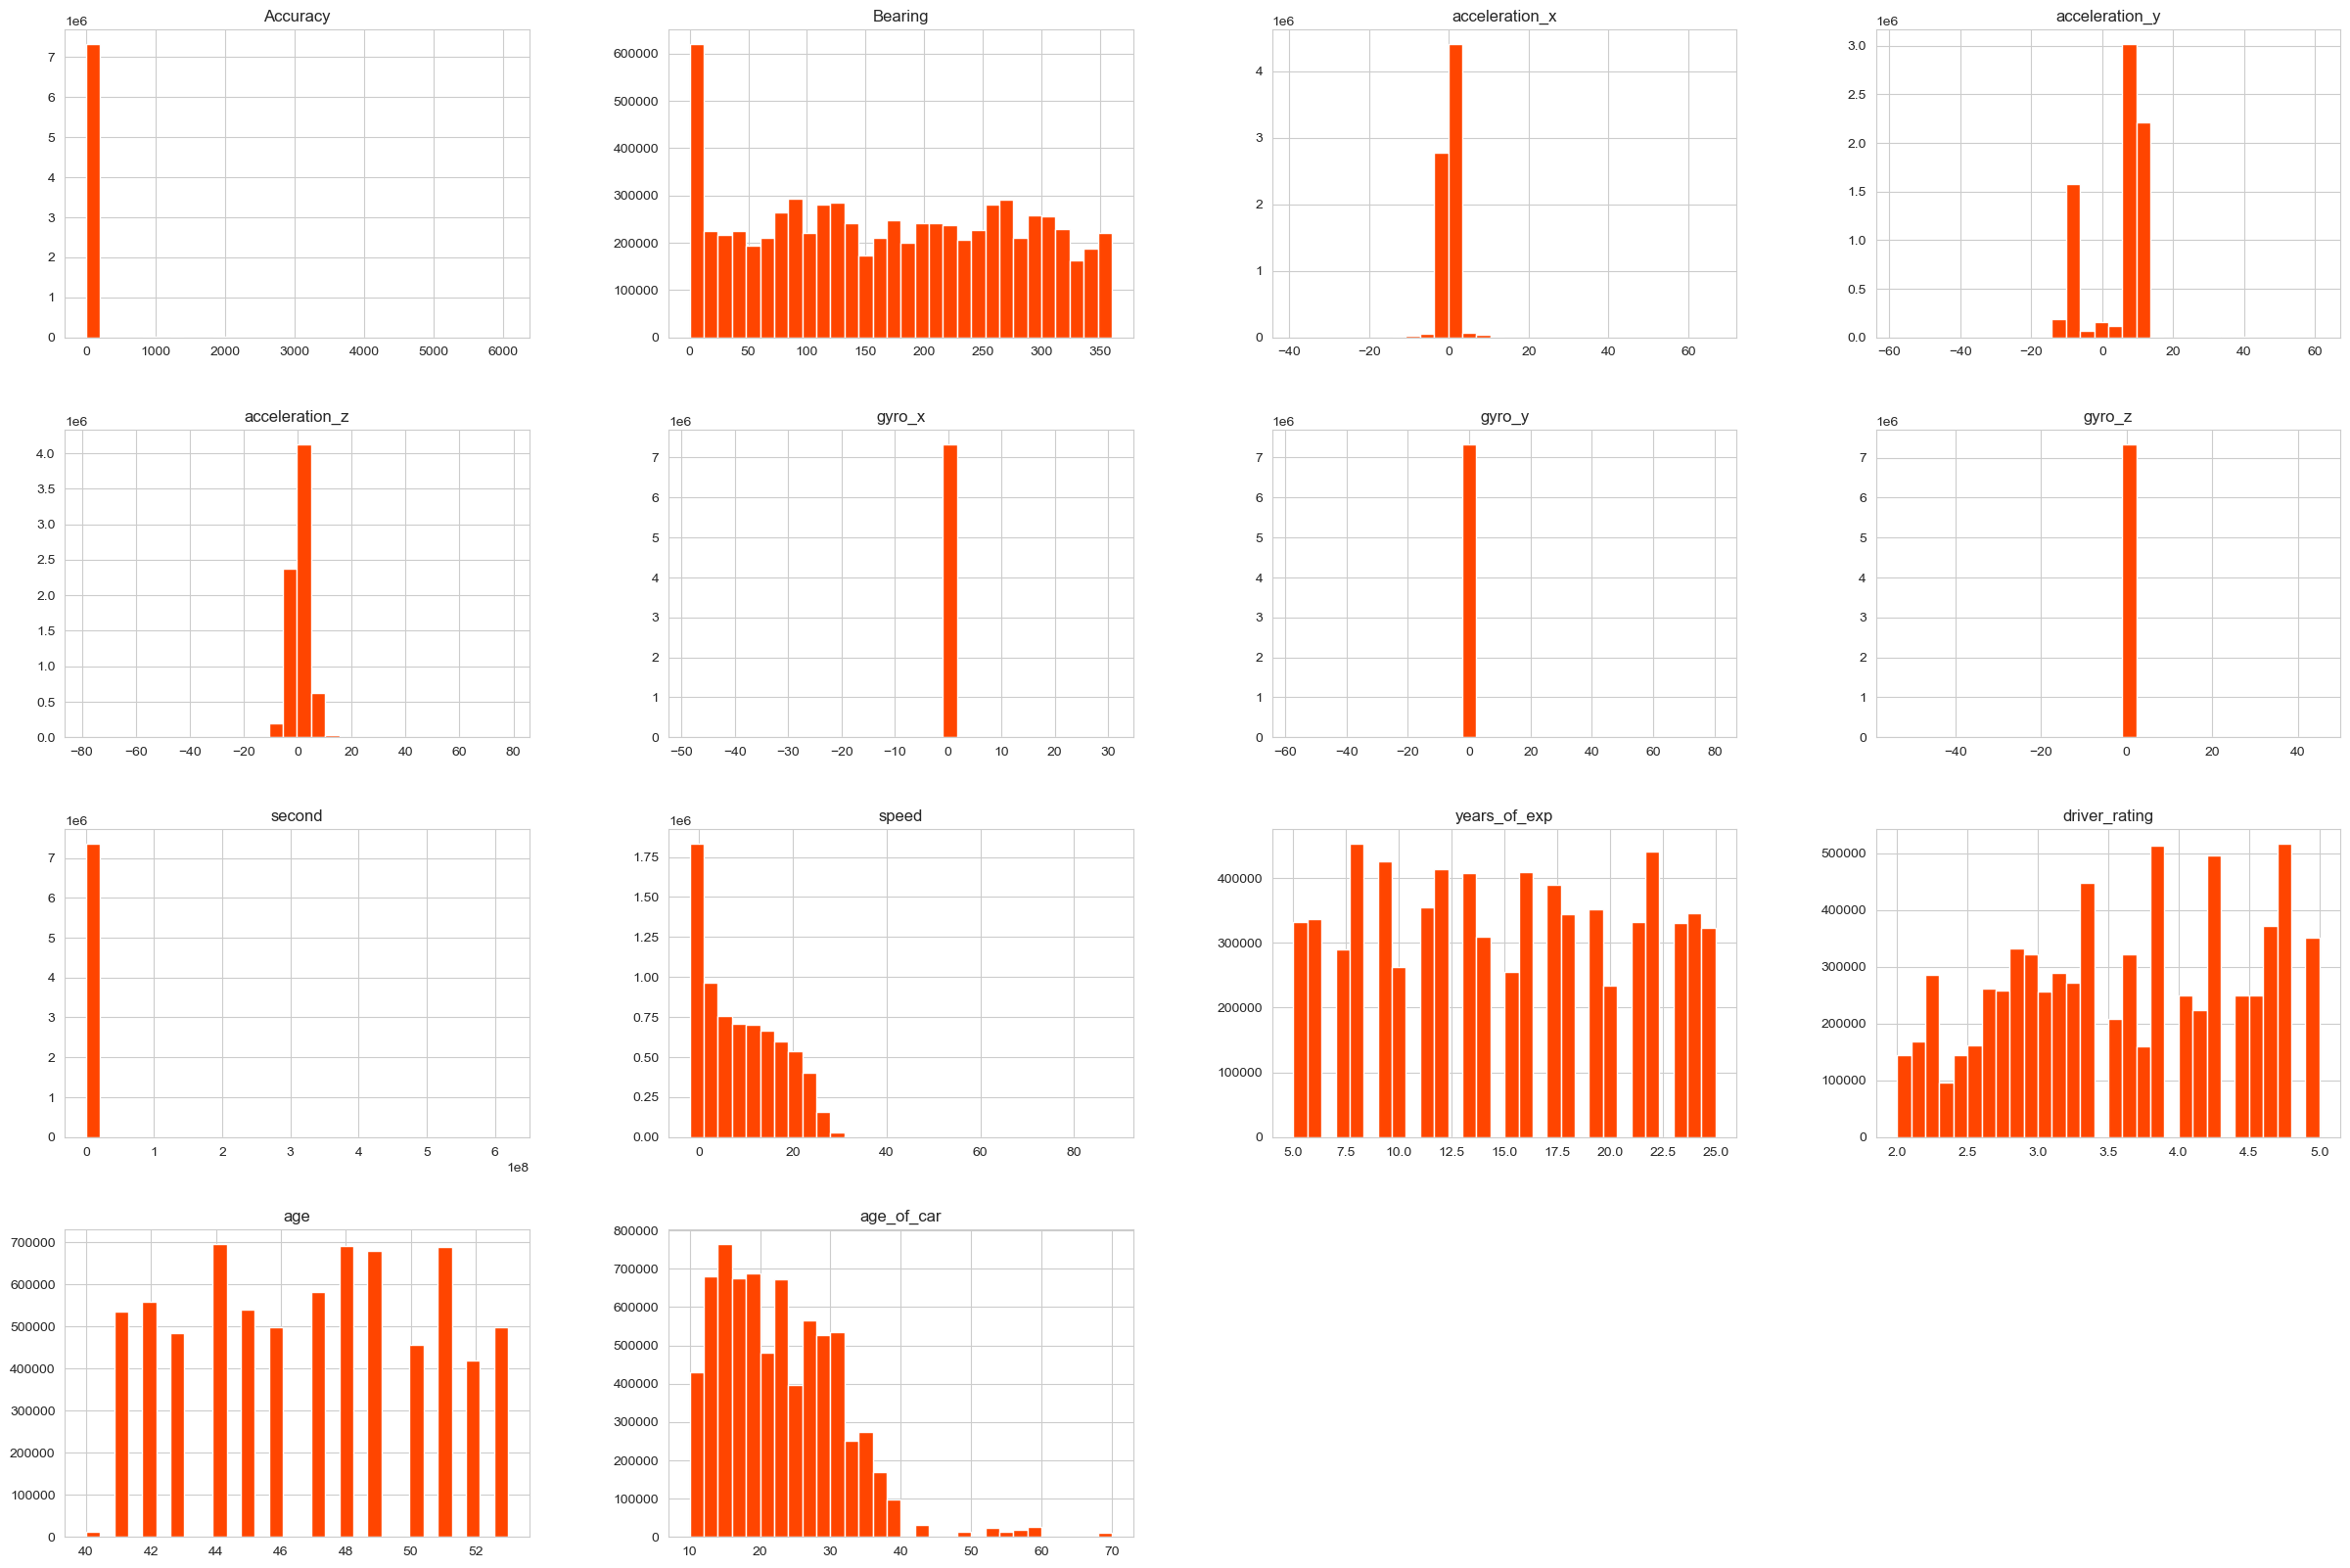

In [113]:
df_new[continuous_cols ].hist(figsize=(30, 20), bins=30, color=palette[0])
plt.show()

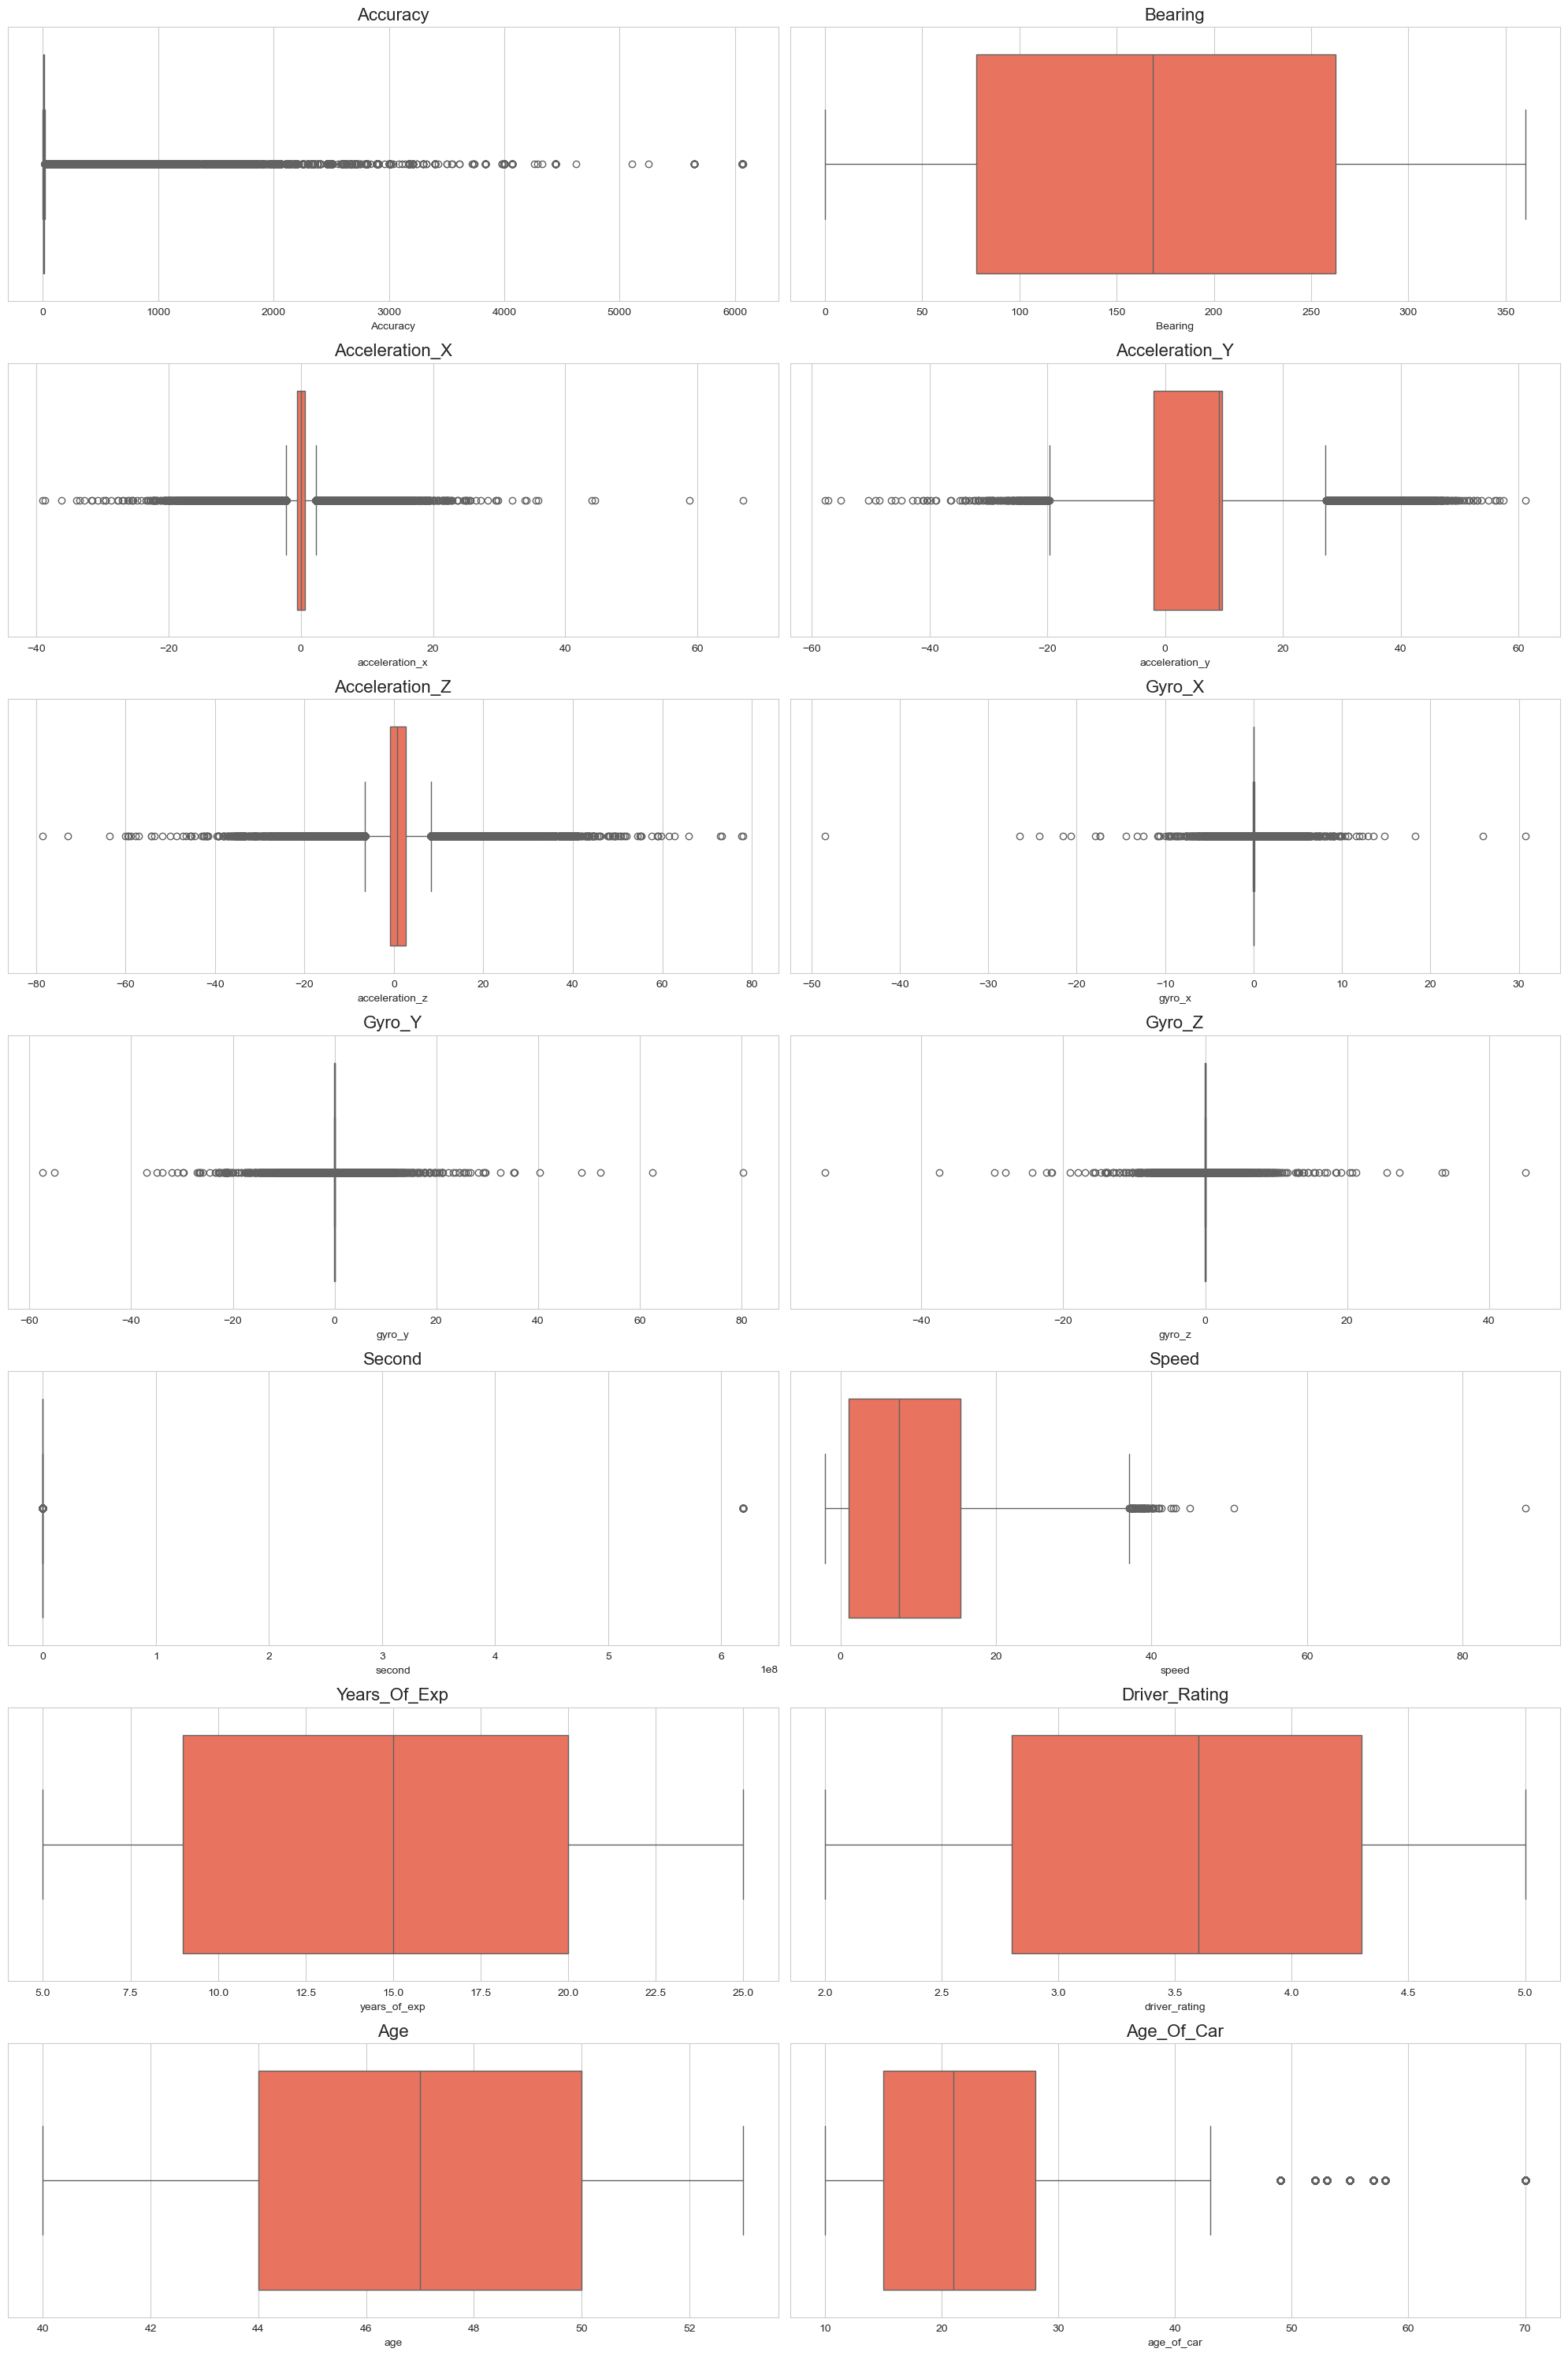

In [121]:
import math
num_cols = 2
num_rows = math.ceil(len(continuous_cols) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 30))
axes = axes.flatten()

for i, col in enumerate(continuous_cols):
    sns.boxplot(x=col, data=df_new, ax=axes[i], color=palette[1])
    axes[i].set_title(f'{col.title()}', fontsize=16)

# # Remove any unused subplots
# if len(continuous_cols) < len(axes):
#     for i in range(len(continuous_cols), len(axes)):
#         fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Observations
- Driver Valera Greenall has the most amount of driver_name's occurances, this suggests that either Valera Greenall has taken alot of bookings or there are more booking records per ride in her case. While Eleanor Bernocchi has the least amount of driver_name's occurances.
- Toyota seems to be the most prefered car for most drivers, while Nissan seems to be the least perferred
- There is a slightly skewed distribution of gender, with males being around 100k more.

In [88]:
df_new['bookingID'].value_counts()

bookingID
438086664371     3456
1374389534819    2057
34359738469      1957
1108101562533    1826
747324309632     1718
                 ... 
1288490188932      47
1322849927281      47
850403524704       46
893353197740       45
317827579936       43
Name: count, Length: 20000, dtype: int64

Observations:
- There are is large difference in amount of records for each bookingID, this could be attributed to the duration of the ride and the accuracy of the sensors recording the data.

### Target Label

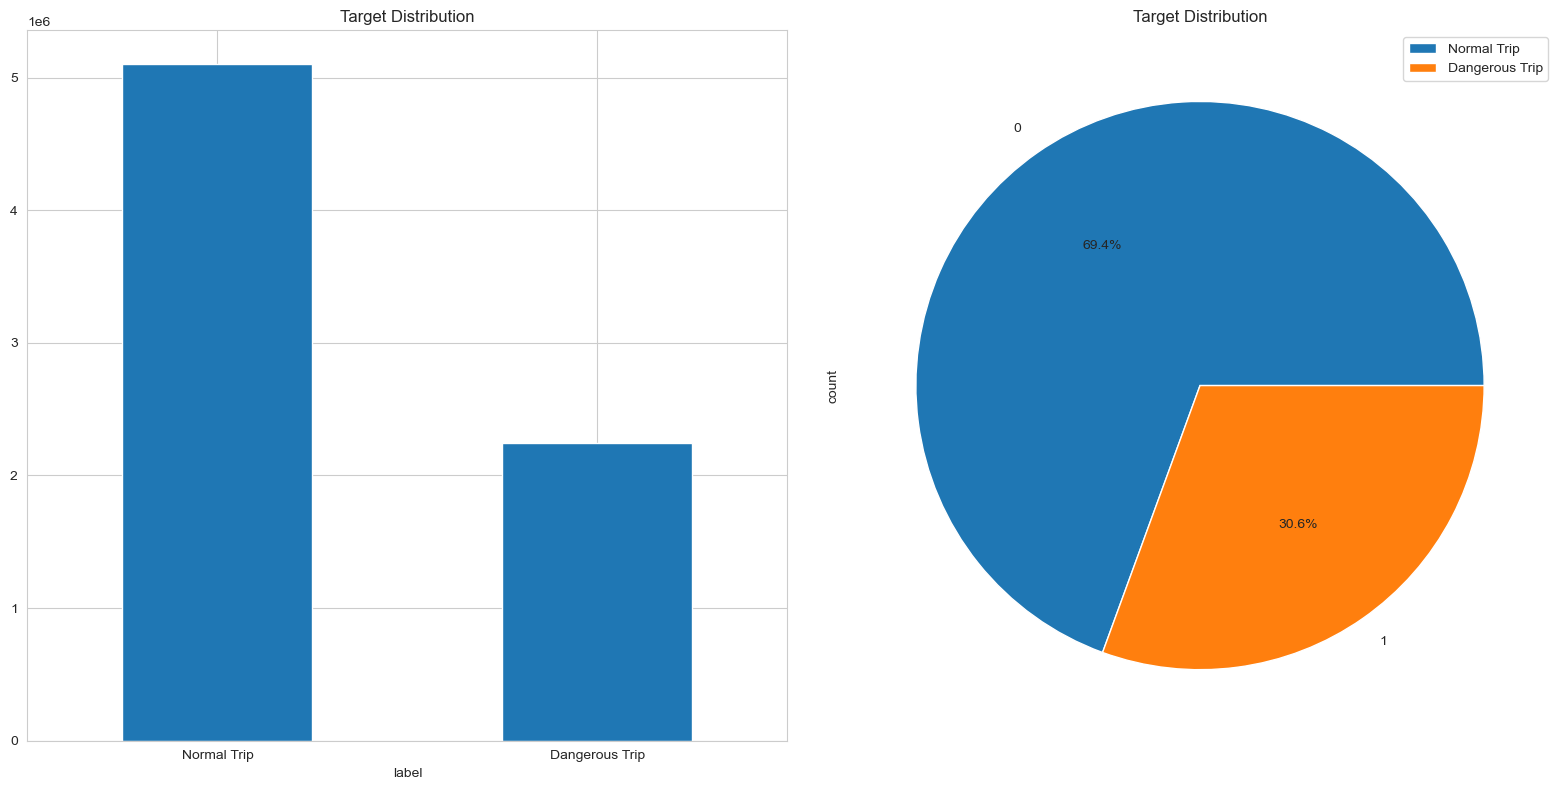

In [89]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(16, 8))

df_new["label"].value_counts().plot(kind='bar', ax=ax, title="Target Distribution")
ax.set_xticklabels(('Normal Trip','Dangerous Trip'), rotation=360)

df_new["label"].value_counts().plot(kind='pie', ax=ax1, title="Target Distribution", autopct='%1.1f%%')
ax1.legend(('Normal Trip','Dangerous Trip'))

plt.tight_layout()
plt.show()

Observations:
-  Our df is imbalance, with Dangerous Trips (labelled : 1) having half the amount as Normal trips. This suggests that we may need to use oversampling techniques for our df when building a machine learning model.
- This class imbalance is a good thing for the company, as it shows its drivers as generally careful in their driving. With 30.6% of it being dangerous

### Correlation Matrix

In [90]:
df_new

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,driver_id,label,driver_name,years_of_exp,gender,car_brand,driver_rating,age,age_of_car
0,0,8.000,143.250,-1.706,-9.273,-1.209,-0.029,-0.033,0.015,2.000,0.000,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699,53,20
1,0,8.000,143.250,-1.417,-9.547,-1.861,-0.022,0.005,-0.026,3.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699,53,20
2,0,8.000,143.250,-0.347,-9.531,-1.205,0.015,-0.050,0.025,9.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699,53,20
3,0,8.000,143.250,-0.601,-9.453,-2.158,0.005,-0.012,-0.004,11.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699,53,20
4,0,8.000,143.250,-0.598,-9.859,-1.673,-0.000,0.000,-0.010,12.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699,53,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526005,996432412828,3.711,87.000,-1.908,8.984,2.711,-0.105,0.442,0.059,1538.000,3.570,420,1,Ringo Wegenen,9,Male,Toyota,3.900,49,11
526006,996432412828,3.650,64.000,-0.910,8.719,2.320,-0.121,0.333,0.090,1539.000,2.980,420,1,Ringo Wegenen,9,Male,Toyota,3.900,49,11
526007,996432412828,3.461,42.000,-2.490,9.492,-0.503,0.061,0.327,0.043,1540.000,2.391,420,1,Ringo Wegenen,9,Male,Toyota,3.900,49,11
526008,996432412828,3.619,3.000,-1.499,10.148,-0.668,0.135,0.243,0.093,1542.000,3.789,420,1,Ringo Wegenen,9,Male,Toyota,3.900,49,11


Observations:
- There is not much correlation between any of our continous variables

In [91]:
df_new

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,driver_id,label,driver_name,years_of_exp,gender,car_brand,driver_rating,age,age_of_car
0,0,8.000,143.250,-1.706,-9.273,-1.209,-0.029,-0.033,0.015,2.000,0.000,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699,53,20
1,0,8.000,143.250,-1.417,-9.547,-1.861,-0.022,0.005,-0.026,3.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699,53,20
2,0,8.000,143.250,-0.347,-9.531,-1.205,0.015,-0.050,0.025,9.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699,53,20
3,0,8.000,143.250,-0.601,-9.453,-2.158,0.005,-0.012,-0.004,11.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699,53,20
4,0,8.000,143.250,-0.598,-9.859,-1.673,-0.000,0.000,-0.010,12.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699,53,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526005,996432412828,3.711,87.000,-1.908,8.984,2.711,-0.105,0.442,0.059,1538.000,3.570,420,1,Ringo Wegenen,9,Male,Toyota,3.900,49,11
526006,996432412828,3.650,64.000,-0.910,8.719,2.320,-0.121,0.333,0.090,1539.000,2.980,420,1,Ringo Wegenen,9,Male,Toyota,3.900,49,11
526007,996432412828,3.461,42.000,-2.490,9.492,-0.503,0.061,0.327,0.043,1540.000,2.391,420,1,Ringo Wegenen,9,Male,Toyota,3.900,49,11
526008,996432412828,3.619,3.000,-1.499,10.148,-0.668,0.135,0.243,0.093,1542.000,3.789,420,1,Ringo Wegenen,9,Male,Toyota,3.900,49,11


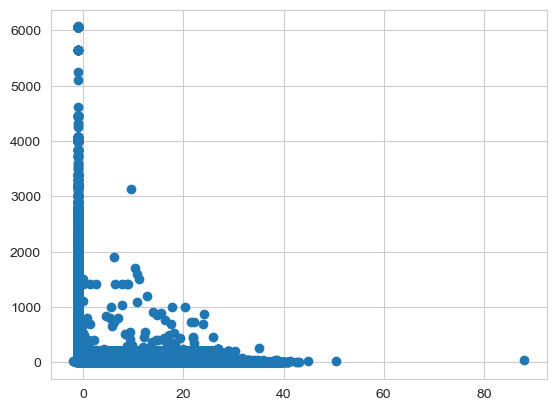

In [92]:
plt.scatter(df_new['speed'], df_new['Accuracy'])
plt.show()

In [93]:
# sns.pairplot(correlationDf, hue='label', palette='Set1')
# plt.show()